/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_54740/449320394.py:10: DtypeWarning:

Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.



Total rows in dataset: 1336925
Rows after filtering NaN coordinates: 1317867

Statistics for Energia primària no renovable:
  min: -48.21
  max: 96535.08
  mean: 210.08
  median: 194.46

Statistics for Emissions de CO2:
  min: -8.17
  max: 60393.00
  mean: 43.65
  median: 39.56

Maps have been saved as: catalonia_energy_emissions_map.png
Individual maps saved as:
- energy_map.png
- emissions_map.png


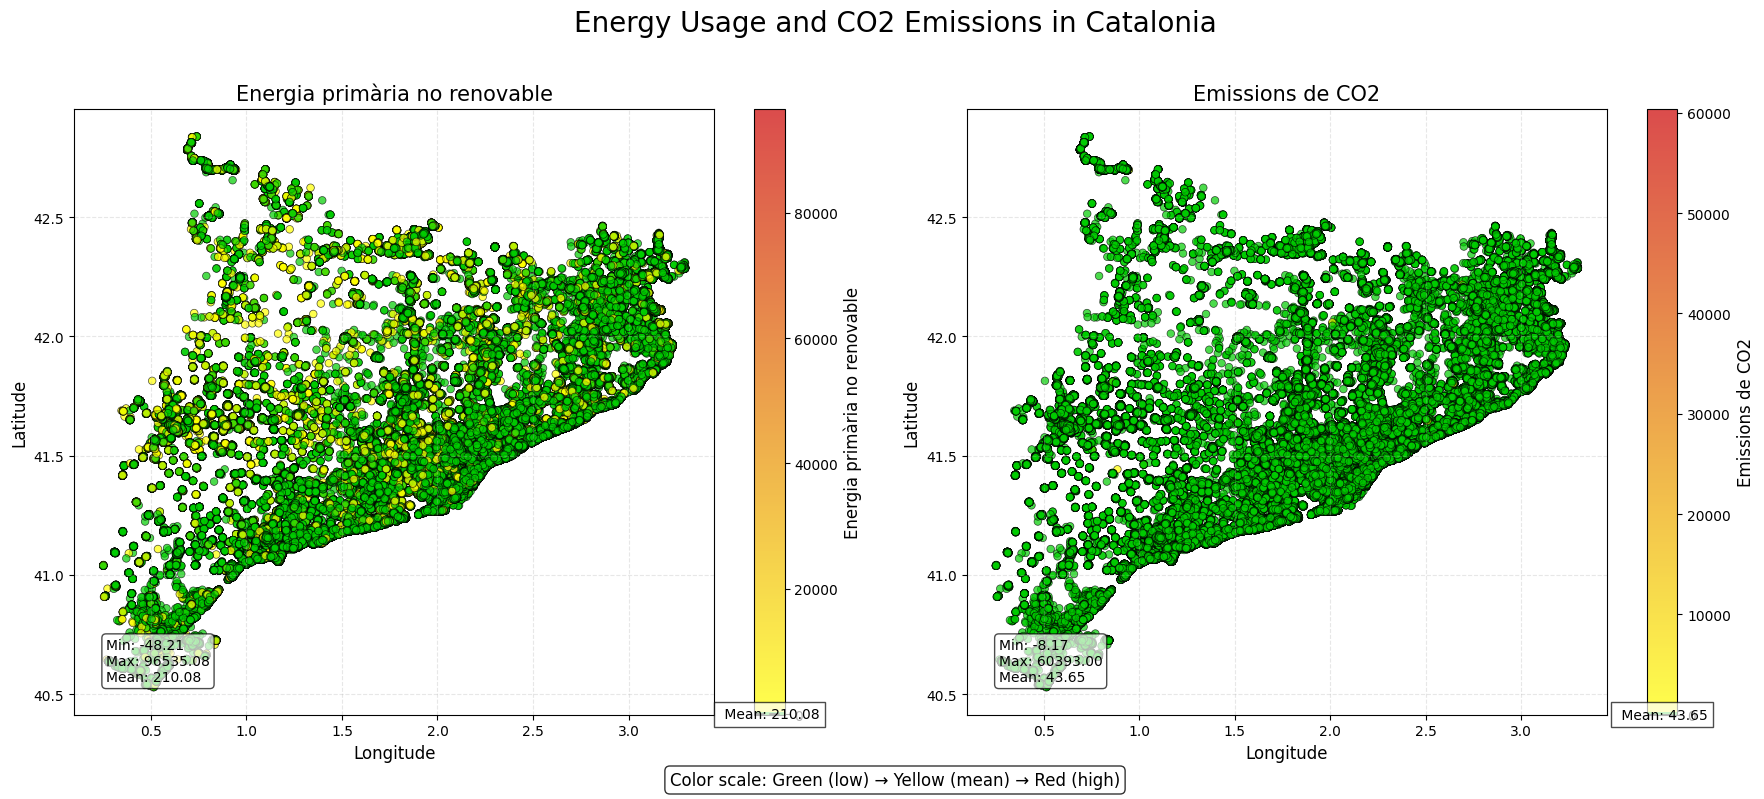

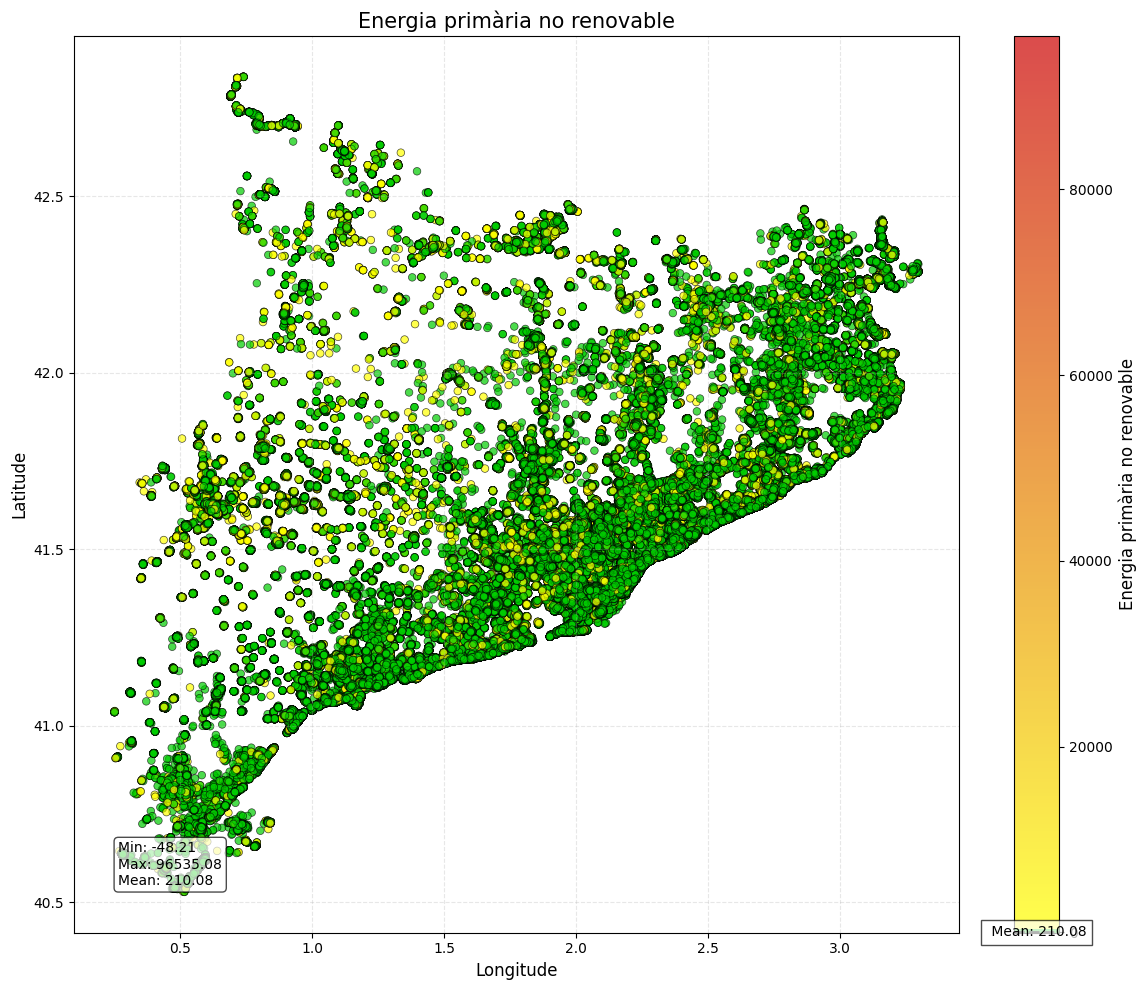

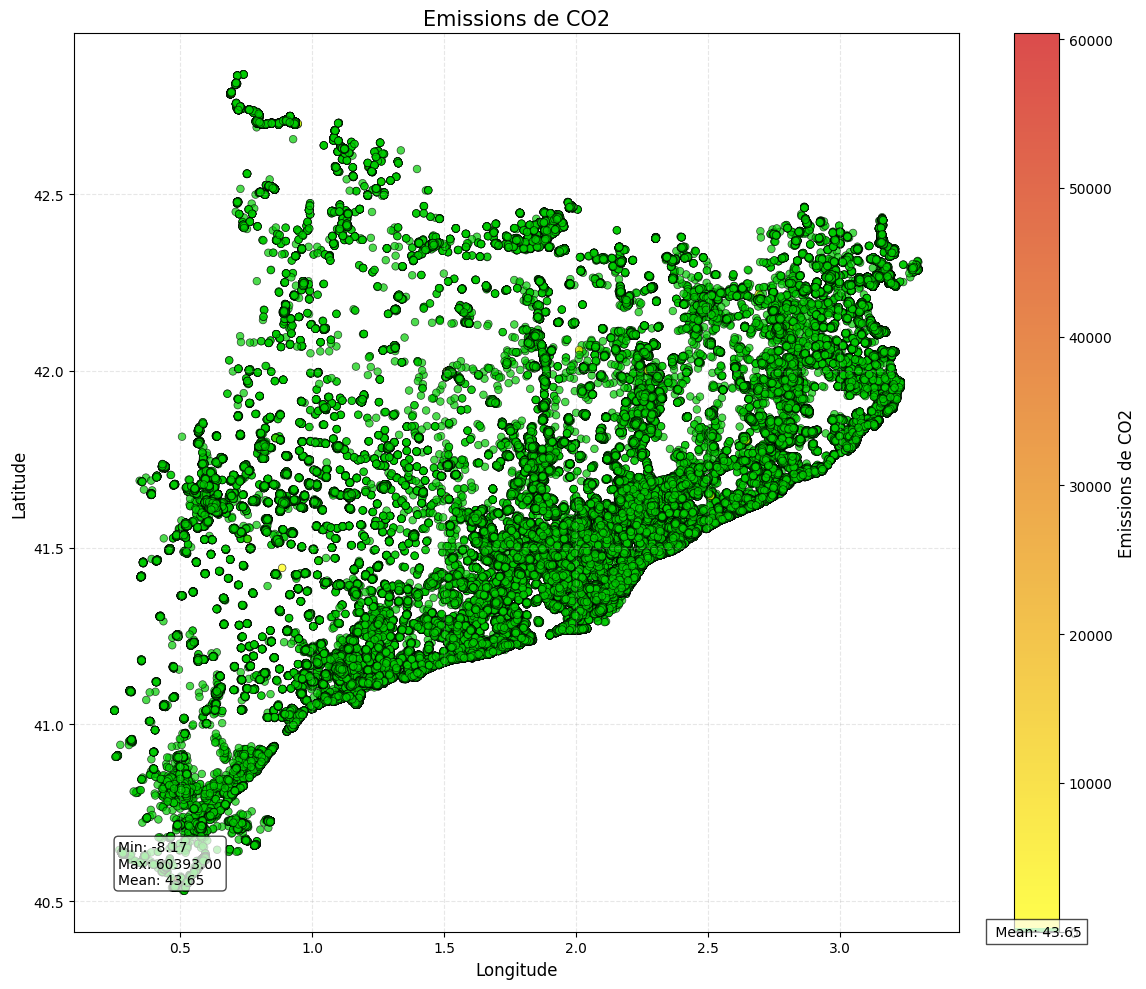

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from matplotlib.widgets import RadioButtons

# Load the data
data = pd.read_csv('data/EPC_Catalonia.csv')

# Filter out rows with NaN values in LONGITUD and LATITUD
filtered_data = data.dropna(subset=['LONGITUD', 'LATITUD'])

# Extract the columns of interest
energy_data = filtered_data[['Energia primària no renovable', 'Emissions de CO2', 'LONGITUD', 'LATITUD', 
                             'Qualificació de consum d\'energia primaria no renovable', 'Qualificacio d\'emissions de CO2']]

# Function to create a custom colormap centered on mean
def create_custom_colormap(values):
    min_val = np.nanmin(values)
    max_val = np.nanmax(values)
    mean_val = np.nanmean(values)
    
    # Normalize the mean between 0 and 1
    mean_normalized = (mean_val - min_val) / (max_val - min_val)
    
    # Create colormap: green -> yellow -> red with yellow at mean
    colors = [(0, 0.8, 0), (1, 1, 0), (0.8, 0, 0)]  # Green, Yellow, Red
    positions = [0, mean_normalized, 1]
    
    return LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

# Function to create a choropleth map for a specific metric
def plot_choropleth(ax, metric_name, basemap=True):
    # Filter out NaN values for this metric
    valid_data = energy_data.dropna(subset=[metric_name])
    
    values = valid_data[metric_name]
    min_val = np.nanmin(values)
    max_val = np.nanmax(values)
    mean_val = np.nanmean(values)
    
    # Create custom colormap
    custom_cmap = create_custom_colormap(values)
    
    # Normalize colors for the current metric
    norm = plt.Normalize(min_val, max_val)
    mean_normalized = (mean_val - min_val) / (max_val - min_val)
    
    # Plot Catalonia shapefile as base map if available

    # Create scatter plot
    scatter = ax.scatter(
        valid_data['LONGITUD'],
        valid_data['LATITUD'],
        c=valid_data[metric_name],
        cmap=custom_cmap,
        norm=norm,
        alpha=0.7,
        s=30,
        edgecolors='black',
        linewidths=0.5
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(metric_name, fontsize=12)
    
    # Mark the mean value on the colorbar
    cbar.ax.axhline(y=mean_normalized, color='black', linestyle='--', linewidth=2)
    cbar.ax.text(0.5, mean_normalized, f' Mean: {mean_val:.2f}', va='center', ha='center', 
                 bbox=dict(facecolor='white', alpha=0.7))
    
    # Add labels and grid
    ax.set_title(f'{metric_name}', fontsize=15)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Add stats annotation
    stats_text = f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nMean: {mean_val:.2f}"
    stats_box = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.05, 0.05, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=stats_box)
    
    return scatter, min_val, max_val, mean_val

# Function to create combined figure
def create_combined_maps():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot energy data
    scatter1, min_energy, max_energy, mean_energy = plot_choropleth(
        ax1, 'Energia primària no renovable')
    
    # Plot emission data
    scatter2, min_emission, max_emission, mean_emission = plot_choropleth(
        ax2, 'Emissions de CO2')
    
    # Add overall title
    fig.suptitle('Energy Usage and CO2 Emissions in Catalonia', fontsize=20)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

# Function to create side-by-side maps with mean-centered colormaps
def create_mean_centered_maps():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot energy data with mean-centered colormap
    energy_values = energy_data['Energia primària no renovable'].dropna()
    scatter1, min_energy, max_energy, mean_energy = plot_choropleth(
        ax1, 'Energia primària no renovable')
    
    # Plot emission data with mean-centered colormap
    emission_values = energy_data['Emissions de CO2'].dropna()
    scatter2, min_emission, max_emission, mean_emission = plot_choropleth(
        ax2, 'Emissions de CO2')
    
    # Add explanation about the color scheme
    color_info = "Color scale: Green (low) → Yellow (mean) → Red (high)"
    fig.text(0.5, 0.01, color_info, ha='center', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
    # Add overall title
    fig.suptitle('Energy Usage and CO2 Emissions in Catalonia', fontsize=20)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    
    return fig

# Main execution function
def main():
    # Print basic information about the dataset
    print(f"Total rows in dataset: {len(data)}")
    print(f"Rows after filtering NaN coordinates: {len(filtered_data)}")
    
    # Calculate statistics for both metrics
    energy_values = energy_data['Energia primària no renovable'].dropna()
    energy_stats = {
        'min': energy_values.min(),
        'max': energy_values.max(),
        'mean': energy_values.mean(),
        'median': energy_values.median()
    }
    
    emission_values = energy_data['Emissions de CO2'].dropna()
    emission_stats = {
        'min': emission_values.min(),
        'max': emission_values.max(),
        'mean': emission_values.mean(),
        'median': emission_values.median()
    }
    
    # Print statistics
    print("\nStatistics for Energia primària no renovable:")
    for stat_name, stat_value in energy_stats.items():
        print(f"  {stat_name}: {stat_value:.2f}")
    
    print("\nStatistics for Emissions de CO2:")
    for stat_name, stat_value in emission_stats.items():
        print(f"  {stat_name}: {stat_value:.2f}")
    
    # Create combined maps figure
    combined_fig = create_mean_centered_maps()
    
    # Save the figure
    combined_fig.savefig('catalonia_energy_emissions_map.png', dpi=300, bbox_inches='tight')
    print("\nMaps have been saved as: catalonia_energy_emissions_map.png")
    
    # Create individual maps with more detailed view
    fig1, ax1 = plt.subplots(figsize=(12, 10))
    plot_choropleth(ax1, 'Energia primària no renovable')
    fig1.tight_layout()
    fig1.savefig('energy_map.png', dpi=300, bbox_inches='tight')
    
    fig2, ax2 = plt.subplots(figsize=(12, 10))
    plot_choropleth(ax2, 'Emissions de CO2')
    fig2.tight_layout()
    fig2.savefig('emissions_map.png', dpi=300, bbox_inches='tight')
    
    print("Individual maps saved as:")
    print("- energy_map.png")
    print("- emissions_map.png")
    
    # Show the combined figure
    plt.show()

if __name__ == "__main__":
    main()

/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_58676/4127469234.py:8: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/EPC_Catalonia.csv')
/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_58676/4127469234.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby("Qualificació de consum d'energia primaria no renovable", group_keys=False).apply(


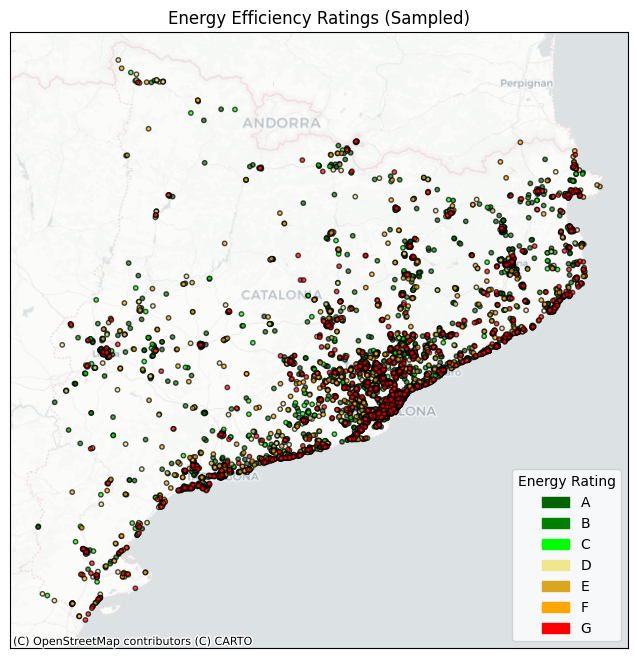

In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import matplotlib.patches as mpatches

data = pd.read_csv('data/EPC_Catalonia.csv')
# Load relevant columns and drop NaNs
df = data[["Qualificació de consum d'energia primaria no renovable", "Qualificacio d'emissions de CO2",
           'LONGITUD', 'LATITUD']].dropna(subset=['LONGITUD', 'LATITUD'])

# -------- STRATIFIED SAMPLING TO REDUCE DATA SIZE --------
# Keep a balanced sample of ~500 points per category
sample_size = 1000
df_sampled = df.groupby("Qualificació de consum d'energia primaria no renovable", group_keys=False).apply(
    lambda x: x.sample(min(len(x), sample_size))
)

# -------- COLOR MAPPING (A-G SCALE) --------
color_scale = {
    'A': 'darkgreen',  
    'B': 'green',  
    'C': 'lime',  
    'D': 'khaki',  
    'E': 'goldenrod',  
    'F': 'orange',  
    'G': 'red'
}

# Convert categorical ratings into colors
df_sampled['color'] = df_sampled["Qualificació de consum d'energia primaria no renovable"].map(color_scale)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df_sampled, geometry=gpd.points_from_xy(df_sampled.LONGITUD, df_sampled.LATITUD), crs="EPSG:4326")

# Reproject to Web Mercator (needed for contextily basemap)
gdf = gdf.to_crs(epsg=3857)

# -------- PLOT MAP --------
fig, ax = plt.subplots(figsize=(10, 8))

# Plot sampled points
gdf.plot(ax=ax, color=gdf['color'], markersize=10, alpha=0.7, edgecolor="black")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.8)

# Formatting
ax.set_title("Energy Efficiency Ratings (Sampled)")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_scale.items()]
ax.legend(handles=legend_patches, title="Energy Rating", loc="lower right")

plt.show()

/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_58676/1040370164.py:8: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/EPC_Catalonia.csv')
/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_58676/1040370164.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby("Qualificacio d'emissions de CO2", group_keys=False).apply(


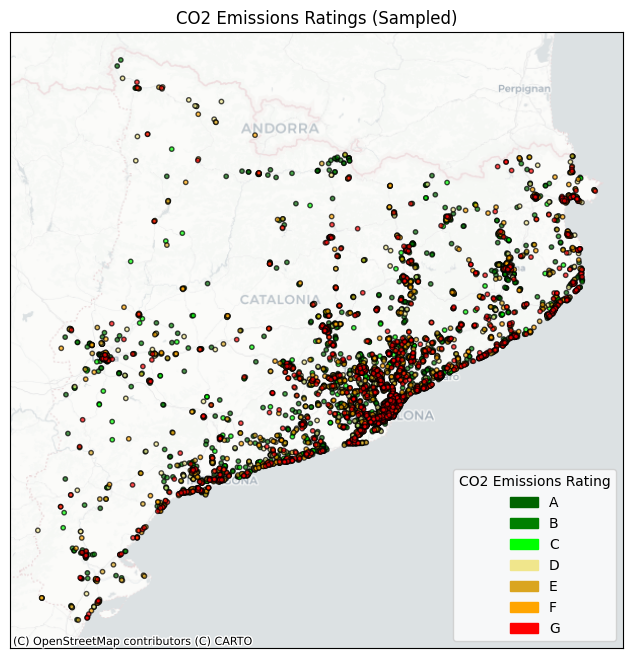

In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import matplotlib.patches as mpatches

data = pd.read_csv('data/EPC_Catalonia.csv')
# Load relevant columns and drop NaNs
df = data[["Qualificació de consum d'energia primaria no renovable", "Qualificacio d'emissions de CO2",
           'LONGITUD', 'LATITUD']].dropna(subset=['LONGITUD', 'LATITUD'])

# -------- STRATIFIED SAMPLING TO REDUCE DATA SIZE --------
# Keep a balanced sample of ~500 points per category
sample_size = 1000
df_sampled = df.groupby("Qualificacio d'emissions de CO2", group_keys=False).apply(
    lambda x: x.sample(min(len(x), sample_size))
)

# -------- COLOR MAPPING (A-G SCALE) --------
color_scale = {
    'A': 'darkgreen',  
    'B': 'green',  
    'C': 'lime',  
    'D': 'khaki',  
    'E': 'goldenrod',  
    'F': 'orange',  
    'G': 'red'
}

# Convert categorical ratings into colors
df_sampled['color'] = df_sampled["Qualificacio d'emissions de CO2"].map(color_scale)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df_sampled, geometry=gpd.points_from_xy(df_sampled.LONGITUD, df_sampled.LATITUD), crs="EPSG:4326")

# Reproject to Web Mercator (needed for contextily basemap)
gdf = gdf.to_crs(epsg=3857)

# -------- PLOT MAP --------
fig, ax = plt.subplots(figsize=(10, 8))

# Plot sampled points
gdf.plot(ax=ax, color=gdf['color'], markersize=10, alpha=0.7, edgecolor="black")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.8)

# Formatting
ax.set_title("CO2 Emissions Ratings (Sampled)")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_scale.items()]
ax.legend(handles=legend_patches, title="CO2 Emissions Rating", loc="lower right")

plt.show()

/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_58676/501999801.py:10: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/EPC_Catalonia.csv')
/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_58676/501999801.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("RdYlGn_r")  # Red (high) to Green (low)


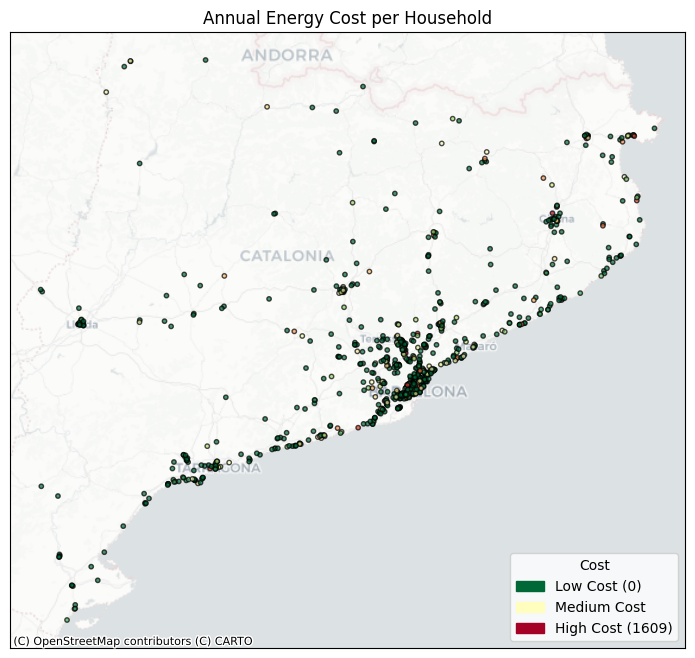

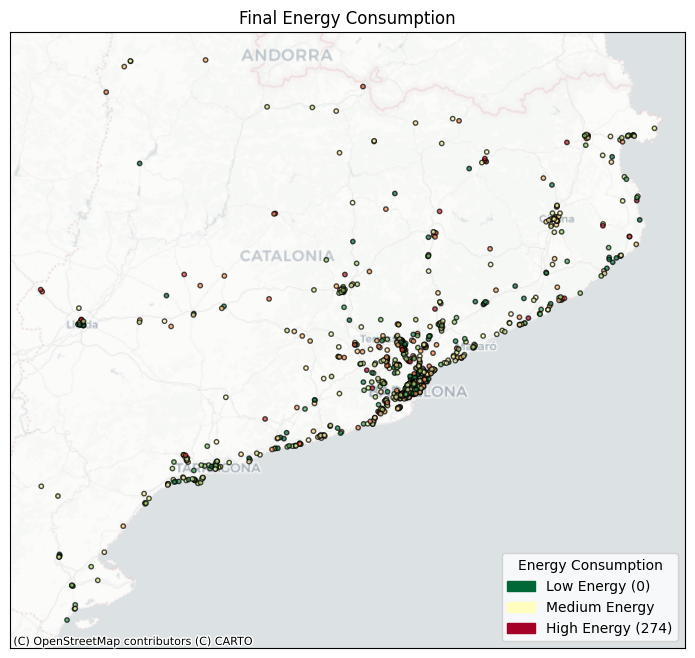

In [23]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Load data
data = pd.read_csv('data/EPC_Catalonia.csv')
df = data[["Consum d'energia final", "Cost anual aproximat d'energia per habitatge",
           'LONGITUD', 'LATITUD']].dropna(subset=['LONGITUD', 'LATITUD'])

# Sample data
sample_size = 1000
df_sampled = df.sample(n=min(len(df), sample_size), random_state=123)

q_low, q_high = df_sampled["Consum d'energia final"].quantile([0.05, 0.95])
df_sampled = df_sampled[(df_sampled["Consum d'energia final"] >= q_low) & (df_sampled["Consum d'energia final"] <= q_high)]

q_low, q_high = df_sampled["Cost anual aproximat d'energia per habitatge"].quantile([0.05, 0.95])
df_sampled = df_sampled[(df_sampled["Cost anual aproximat d'energia per habitatge"] >= q_low) & (df_sampled["Cost anual aproximat d'energia per habitatge"] <= q_high)]



# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df_sampled, geometry=gpd.points_from_xy(df_sampled.LONGITUD, df_sampled.LATITUD), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)  # Reproject to Web Mercator for basemap

# Define colormap
colormap = cm.get_cmap("RdYlGn_r")  # Red (high) to Green (low)

# --- Plot 1: Cost Only ---
# Normalize cost values
cost_min = df_sampled["Cost anual aproximat d'energia per habitatge"].min()
cost_max = df_sampled["Cost anual aproximat d'energia per habitatge"].max()
gdf["normalized_cost"] = (df_sampled["Cost anual aproximat d'energia per habitatge"] - cost_min) / (cost_max - cost_min)
gdf["cost_color"] = gdf["normalized_cost"].apply(lambda x: mcolors.to_hex(colormap(x)))

fig1, ax1 = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax1, color=gdf["cost_color"], markersize=10, alpha=0.7, edgecolor="black")
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, alpha=0.8)

ax1.set_title("Annual Energy Cost per Household")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("")
ax1.set_ylabel("")

# Cost legend
cost_legend = [
    mpatches.Patch(color="#006837", label=f"Low Cost ({cost_min:.0f})"),
    mpatches.Patch(color=mcolors.to_hex(colormap(0.5)), label="Medium Cost"),
    mpatches.Patch(color="#a50026", label=f"High Cost ({cost_max:.0f})")
]
ax1.legend(handles=cost_legend, title="Cost", loc="lower right")

# --- Plot 2: Energy Only ---
# Normalize energy values
energy_min = df_sampled["Consum d'energia final"].min()
energy_max = df_sampled["Consum d'energia final"].max()
gdf["normalized_energy"] = (df_sampled["Consum d'energia final"] - energy_min) / (energy_max - energy_min)
gdf["energy_color"] = gdf["normalized_energy"].apply(lambda x: mcolors.to_hex(colormap(x)))

fig2, ax2 = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax2, color=gdf["energy_color"], markersize=10, alpha=0.7, edgecolor="black")
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, alpha=0.8)

ax2.set_title("Final Energy Consumption")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")

# Energy legend
energy_legend = [
    mpatches.Patch(color="#006837", label=f"Low Energy ({energy_min:.0f})"),
    mpatches.Patch(color=mcolors.to_hex(colormap(0.5)), label="Medium Energy"),
    mpatches.Patch(color="#a50026", label=f"High Energy ({energy_max:.0f})")
]
ax2.legend(handles=energy_legend, title="Energy Consumption", loc="lower right")

# Show both plots
plt.show()